# Lab 5: Wide & Deep Networks

### *Harrison Noble & Henry Lambson*

***

__Dataset Selection__

For this lab, we will be switching the dataset we have been using for table data. In our previous table data labs, we used the wine quality dataset. However, this lab requires that our dataset needs at least 2 categorical features and the wine quality dataset only contains 1 categorical feature.

Our new dataset is the HR Analytics Case Study dataset (Kaggle) which contains many features about 4410 employees. The classification task for this dataset is to determine if an employee is going to quit or stay at the company (binary classification). This dataset is seperated into many different files, these files include: general employee data (24 features such as age, distance from home, education level, etc.), employee survey data (satisfaction levels, etc.), and manager surveys about the employees (performance rating and involvement). This dataset also has two files containing a timeseries of when the employee clocked in and when they clocked out over a 262 day period. This timeseries data is most likely going to be transformed into an "average time spent working" feature for each employee. 

The dataset can be found here: https://www.kaggle.com/vjchoudhary7/hr-analytics-case-study [1]

***

## 1 Preparation

### 1.1 Define & Prepare Class Variables

Below is our code that loads our dataset, removing any data that is unneeded, scales the data, and encodes the data.

In [1]:
#some data prep code taken from https://www.kaggle.com/artyomkolas/hr-analytics-2 [2]
#code taken will be referenced using the '[2]' comment
import pandas as pd

#read all csv files
general_data = pd.read_csv('general_data.csv')
empl_survey = pd.read_csv('employee_survey_data.csv')
mngr_survey = pd.read_csv('manager_survey_data.csv')
in_time = pd.read_csv('in_time.csv')
out_time = pd.read_csv('out_time.csv')

#concatenate dataframes other than time series data (join on EmployeeID)
#--------------- (All code below taken from [2]) #---------------
df = pd.concat([general_data.set_index('EmployeeID'), 
                empl_survey.set_index('EmployeeID'),
                mngr_survey.set_index('EmployeeID')], 
               axis=1, 
               join='inner').reset_index()

#create avg clock in/out time, avg work day, and number of days off feature from time data
weekends = ['2015-12-25', '2015-10-02', '2015-11-11', '2015-05-01', '2015-01-14', 
            '2015-11-10', '2015-03-05', '2015-07-17', '2015-01-26', '2015-11-09', 
            '2015-09-17', '2015-01-01']
#first do the in time
in_time.iloc[:,1:] = in_time.iloc[:,1:].astype('datetime64[ns]')
in_time.rename({'Unnamed: 0': 'EmployeeID'}, axis=1, inplace=True)
in_time.drop(weekends, axis=1, inplace=True)
df_in = pd.DataFrame()
for col in in_time.columns[1:]:
    time = pd.DatetimeIndex(in_time[col])
    df_in[col] = (time.hour * 60 + time.minute)/60
    
#now do the out time
out_time.iloc[:,1:] = out_time.iloc[:,1:].astype('datetime64[ns]')
out_time.rename({'Unnamed: 0': 'EmployeeID'}, axis=1, inplace=True)
out_time.drop(weekends, axis=1, inplace=True)
df_out = pd.DataFrame()
for col in in_time.columns[1:]:
    time = pd.DatetimeIndex(out_time[col])
    df_out[col] = (time.hour * 60 + time.minute)/60
    
#create new features and concatenate dataframes together
df_time = pd.DataFrame()
df_time['EmployeeID'] = in_time['EmployeeID']
df_time['in_avg'] = df_in.iloc[:, 1:].mean(axis=1)
df_time['out_avg'] = df_out.iloc[:,1:].mean(axis=1)
df_time['avg_work_day'] = df_time['out_avg'] - df_time['in_avg']
df_time['num_day_off'] = df_in.isnull().sum(axis=1)
df =  pd.concat([df.set_index('EmployeeID'), 
                 df_time.set_index('EmployeeID')],
                axis=1, 
                join='inner').reset_index()
df.reset_index(drop=True, inplace=True)
#--------------- (All code above taken from [2]) #---------------

In the above code block, we load each CSV file into a seperate dataframe. We then concatenate these dataframes together using the shared EmployeeID column in order to get one dataframe to work with. Next, we process the clock in and clock out dataframes in order to calculate the average time the employee clocks in and out along with their average work day, and number of days off. Finally, we create a temporary dataframe to hold the values for these columns and then concatenate it to the large dataframe.  

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

#drop all rows with NA values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

#drop all columns with uneeded (features with 1 unique value and EmployeeID) data
df.drop([c for c in list(df) if len(df[c].unique()) <= 1], inplace=True, axis=1)
df.drop(['EmployeeID'], inplace=True, axis=1)

#code taken from [2]
integer  = ['TotalWorkingYears', 'EnvironmentSatisfaction', 'JobSatisfaction', 
            'WorkLifeBalance', 'NumCompaniesWorked']
for col in integer:
    df[[col]] = df[[col]].astype('int64')
#------------------

#normalize all continuous data
continuous = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked',
              'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
              'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
              'in_avg', 'out_avg', 'avg_work_day', 'num_day_off']
std_scaler = StandardScaler()
df[continuous] = std_scaler.fit_transform(df[continuous])
    
#for every object datatype, encode as integer
categorical = df.select_dtypes(include='object').columns
for col in df.select_dtypes(include='object').columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    
#show df
pd.set_option('display.max_columns', None)
df

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,in_avg,out_avg,avg_work_day,num_day_off
0,1.538800,0,2,2,-0.394993,2,1,0,1,0,1,1.405193,-0.677226,-1.149725,0,-1.320442,2.483520,-0.980272,-0.677926,-1.159067,3,4,2,3,3,0.136450,-0.242485,-0.244367,0.777304
1,-0.648079,1,1,1,0.099071,1,1,0,1,6,2,-0.492557,-1.077952,2.126858,1,-0.678523,0.157924,-0.329582,-0.368371,-0.037179,3,2,4,2,4,-0.670422,0.000711,0.009780,0.049269
2,-0.538735,0,1,1,0.963683,4,4,1,4,7,1,2.725773,-0.677226,-0.057531,3,-0.806907,-0.617274,-0.329582,-0.677926,-0.317651,2,2,1,3,3,1.307262,-0.494769,-0.512525,-1.042783
3,0.117329,0,0,1,-0.889057,5,1,1,3,1,1,0.385846,0.124225,-1.149725,3,0.220163,1.708321,0.158435,1.488960,0.243293,4,4,3,2,3,-1.012510,-0.393523,-0.379885,0.231278
4,-0.538735,0,2,1,0.099071,1,3,1,1,7,2,-0.885202,0.524950,-0.876677,2,-0.293372,-0.617274,-0.166910,-0.677926,-0.037179,4,1,3,3,3,-0.200165,0.223081,0.225822,-1.588808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4295,-0.866767,0,2,2,-0.642025,3,4,0,2,1,2,-0.630737,-0.677226,0.761615,0,-0.678523,-0.617274,-0.166910,-0.368371,0.243293,3,4,3,2,3,-0.103183,-0.305294,-0.303943,-1.224791
4296,0.554704,0,2,1,-0.518509,4,3,0,1,6,2,-0.101400,0.124225,0.488567,1,-0.164988,1.708321,-0.654927,-0.677926,-0.598123,4,1,3,3,3,1.231685,0.628083,0.611515,-1.224791
4297,-0.866767,0,2,1,-0.889057,4,3,1,1,2,0,-0.813561,-0.276501,-0.057531,0,-0.164988,-0.617274,-0.654927,-0.677926,-0.598123,4,4,3,2,3,0.232493,-1.196274,-1.199597,-0.860774
4298,-1.304143,0,2,1,1.951811,2,1,1,2,7,1,-0.596086,-1.077952,1.307712,0,-0.806907,0.933123,-0.492255,-0.368371,-0.598123,1,3,3,3,4,-1.125802,-0.010801,0.004426,0.959313


In this block, we clean the data by dropping all instances that contain any null values, dropped all columns with only one unique value since they will have no use to us, and drop the EmployeeID column because it has no use as it is an arbitrary number. We then convert TotalWorkingYears, EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance, and NumCompaniesWorked from floats to ints because they are all whole numbers. We did this so that we could use StandardScalar to normalize all columns with continuous values, and make all categorical columns ints. Finally, we encoded all columns with categorical data to ints. 

As we can see in the table above, this is what our data looks like before adding crossed categorical features. The Attrition column is our classification task. Attrition signifies if the employee quit (1) or if the employee stayed at the company (0).

In [3]:
#rename 'Attrition' column to 'Quit' (0 = didn't quit, 1 = quit)
df.rename(columns={'Attrition': 'Quit'}, inplace=True)

#save quit column as y
y = df.Quit
#drop quit column from df and save as X
X = df.drop(['Quit'], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4300 entries, 0 to 4299
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4300 non-null   float64
 1   BusinessTravel           4300 non-null   int64  
 2   Department               4300 non-null   int64  
 3   DistanceFromHome         4300 non-null   float64
 4   Education                4300 non-null   int64  
 5   EducationField           4300 non-null   int64  
 6   Gender                   4300 non-null   int64  
 7   JobLevel                 4300 non-null   int64  
 8   JobRole                  4300 non-null   int64  
 9   MaritalStatus            4300 non-null   int64  
 10  MonthlyIncome            4300 non-null   float64
 11  NumCompaniesWorked       4300 non-null   float64
 12  PercentSalaryHike        4300 non-null   float64
 13  StockOptionLevel         4300 non-null   int64  
 14  TotalWorkingYears       

As shown here, all columns contain no null values, the prediction task (Attrition/Quit) is no longer in the dataframe, and all of our columns are either normalized or encoded, perfect for a deep learning model. Every column that is an int is a categorical feature, and every column that is a float is a normalized continuous feature. 

To get a better understanding of each feature, we decided to output the "data_dictionary" excel file which contains descriptions of all the features (besides the timeseries data we created earlier on in the code). 

In [4]:
desc = pd.read_excel('data_dictionary.xlsx')
pd.set_option('display.max_colwidth', None)
desc

,Variable,Meaning,Levels
0,Age,Age of the employee,NaN
1,Attrition,Whether the employee left in the previous year or not,NaN
2,BusinessTravel,How frequently the employees travelled for business purposes in the last year,NaN
3,Department,Department in company,NaN
4,DistanceFromHome,Distance from home in kms,NaN
5,Education,Education Level,1 'Below College'
6,NaN,NaN,2 'College'
7,NaN,NaN,3 'Bachelor'
8,NaN,NaN,4 'Master'
9,NaN,NaN,5 'Doctor'


### 1.2 Identify Features That Should Be Combined Into Cross-Product Features

Below is our code to combine categorical features into cross-product features. Our selected categorical features can be seen in the ```cross_cols``` list. 

In [5]:
import numpy as np

cross_cols = [['JobLevel', 'StockOptionLevel'],
              ['EnvironmentSatisfaction', 'JobSatisfaction', 'JobInvolvement'],
              ['PerformanceRating', 'JobInvolvement'],
              ['Education', 'JobLevel'],
              ['BusinessTravel', 'JobLevel']]

cross_col_df_names = []
for col_list in cross_cols:
    enc = LabelEncoder()
    X_cross = X[col_list].astype(str)
    X_cross = X_cross.apply(lambda val: '_'.join(val), axis=1)
    cross_col_name = '_'.join(col_list)

    enc.fit(X_cross.to_numpy())

    X[cross_col_name] = enc.transform(X_cross)
    
    cross_col_df_names.append(cross_col_name)

for cross in cross_col_df_names:
    print(len(X[cross].unique()))
    
cross_col_df_names

20
64
8
25
15


['JobLevel_StockOptionLevel',
 'EnvironmentSatisfaction_JobSatisfaction_JobInvolvement',
 'PerformanceRating_JobInvolvement',
 'Education_JobLevel',
 'BusinessTravel_JobLevel']

In [6]:
X

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,in_avg,out_avg,avg_work_day,num_day_off,JobLevel_StockOptionLevel,EnvironmentSatisfaction_JobSatisfaction_JobInvolvement,PerformanceRating_JobInvolvement,Education_JobLevel,BusinessTravel_JobLevel
0,1.538800,2,2,-0.394993,2,1,0,1,0,1,1.405193,-0.677226,-1.149725,0,-1.320442,2.483520,-0.980272,-0.677926,-1.159067,3,4,2,3,3,0.136450,-0.242485,-0.244367,0.777304,0,46,2,5,10
1,-0.648079,1,1,0.099071,1,1,0,1,6,2,-0.492557,-1.077952,2.126858,1,-0.678523,0.157924,-0.329582,-0.368371,-0.037179,3,2,4,2,4,-0.670422,0.000711,0.009780,0.049269,1,37,5,0,5
2,-0.538735,1,1,0.963683,4,4,1,4,7,1,2.725773,-0.677226,-0.057531,3,-0.806907,-0.617274,-0.329582,-0.677926,-0.317651,2,2,1,3,3,1.307262,-0.494769,-0.512525,-1.042783,15,22,2,18,8
3,0.117329,0,1,-0.889057,5,1,1,3,1,1,0.385846,0.124225,-1.149725,3,0.220163,1.708321,0.158435,1.488960,0.243293,4,4,3,2,3,-1.012510,-0.393523,-0.379885,0.231278,11,61,1,22,2
4,-0.538735,2,1,0.099071,1,3,1,1,7,2,-0.885202,0.524950,-0.876677,2,-0.293372,-0.617274,-0.166910,-0.677926,-0.037179,4,1,3,3,3,-0.200165,0.223081,0.225822,-1.588808,2,50,2,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4295,-0.866767,2,2,-0.642025,3,4,0,2,1,2,-0.630737,-0.677226,0.761615,0,-0.678523,-0.617274,-0.166910,-0.368371,0.243293,3,4,3,2,3,-0.103183,-0.305294,-0.303943,-1.224791,4,45,1,11,11
4296,0.554704,2,1,-0.518509,4,3,0,1,6,2,-0.101400,0.124225,0.488567,1,-0.164988,1.708321,-0.654927,-0.677926,-0.598123,4,1,3,3,3,1.231685,0.628083,0.611515,-1.224791,1,50,2,15,10
4297,-0.866767,2,1,-0.889057,4,3,1,1,2,0,-0.813561,-0.276501,-0.057531,0,-0.164988,-0.617274,-0.654927,-0.677926,-0.598123,4,4,3,2,3,0.232493,-1.196274,-1.199597,-0.860774,0,61,1,15,10
4298,-1.304143,2,1,1.951811,2,1,1,2,7,1,-0.596086,-1.077952,1.307712,0,-0.806907,0.933123,-0.492255,-0.368371,-0.598123,1,3,3,3,4,-1.125802,-0.010801,0.004426,0.959313,4,10,6,6,11


We decided to cross-product features that we believed would be related to one another. We think that JobLevel and StockOptionLevel will be highly correlated because the higher your position, the more stock options you would have. EvironmentSatisfaction JobSatisfaction go hand in hand, and changes in one will most likely affect the other. We also believe that JobInvolvement should be crossed with these two because the more an employee enjoys their work, the more involved they will be. Performance Rating and JobInvolvement are also likely to be correlated, as if an employee is not involved with their job, they are likely to recieve a poor performance rating. Education and JobLevel are crossed because for the most part, the better your education, the better the job you will get. Finally, we believe BusinessTravel and JobTravel could be related but we want to explore this to see if there is a correlation between high job level and high travel and how it will affect our deep learning model.  

As we can see from the integers output above, we have 20 different values for JobLevel/StockOption feature cross, 64 different values for EnvironmentSatisfaction/JobSatisfaction/JobInvolvement feature cross, 8 different values for PerformanceRating/JobInvolvement feature cross, 25 different values for Education/JobLevel feature cross, and finally, 15 different values for BusinessTravel/JobLevel feature cross. 

### 1.3 Evaluation Metric(s)

We decided to use the F1-score evaluation metric because our dataset has a large imbalance in our target classes. As we can see below, only ~16% of the data contains employees who quit, while the other ~84% are employees who stayed with the company. Accuracy would be a poor measurement for this dataset, since by just guessing stay, the model would be correct 84% of the time. F1-score takes into account the class imbalance to give us an accurate reading of how well the model performs in our binary classification task.       

Ratio of quit to total employees: 16.16
Number of instances in each class: [3605  695]


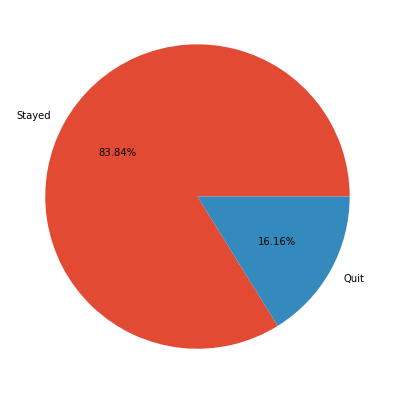

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

print(f"Ratio of quit to total employees: %.2f" % (len(y[y == 1])/len(y) * 100))
print('Number of instances in each class:',np.bincount(y))

fig = plt.figure(figsize=(7, 7))
plt.pie(np.bincount(y), labels=['Stayed', 'Quit'], autopct='%.2f%%')
plt.show()

F1-score is suited well for our business case because the majority of the time, employers collecting data on their employees on whether they quit or not, is going to be an imbalanced dataset. We also do not want the model to accidentally say employees may quit when they plan to stay as this could lead to bias from the employer causing them to make incorrect decisions about their employees (e.g. not giving them raises when they deserve them, etc). 

### 1.4 Method For Dividing Dataset Into Training & Testing

For dividing our dataset into training and testing sets, we decided to use Stratified K-Fold cross validation. In our instance, we decided to use 5 folds since this will yeild 80% data for training and 20% for testing. By choosing Stratified K-Fold we make sure to preserve the overall percentage of classes in each fold (about 16% of instances will be employees who quit, 84% of instances will be employees who stayed). Since our dataset is relatively small and imbalanced, we want to use Stratified K-Fold over regular K-Fold (our research on this method found at [3]).

We think this cross validation method is a realistic mirroring of how an algorithm would be used in practice because small businesses won't have access to their employee data of this scale (according to [4], small businesses make up 99.9% of all businesses in the US and a great majority of them only have 1-19 employees). Since K-Fold cross validation is good for small datasets and Stratified K-Fold is good for imbalanced small datasets, small businesses attempting to create a machine learning model of this nature would most likely be using Stratified K-Fold methods for splitting their data. 

In [8]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, test_idx in cv.split(X.to_numpy(), y.to_numpy()):
    y_train, y_test = y[train_idx], y[test_idx]
    print('Number of instances in train set broken down by class:', 
          np.bincount(y_train), 
          'and test set:', 
          np.bincount(y_test))

Number of instances in train set broken down by class: [2884  556] and test set: [721 139]
Number of instances in train set broken down by class: [2884  556] and test set: [721 139]
Number of instances in train set broken down by class: [2884  556] and test set: [721 139]
Number of instances in train set broken down by class: [2884  556] and test set: [721 139]
Number of instances in train set broken down by class: [2884  556] and test set: [721 139]


Looking at the above output, we can see that there are 2884 employees who stayed and 556 employees who quit for each training set. The testing set contains around 721 employees who stayed and 139 employees who quit. By doing the math, we can see that both the training and testing sets for each fold contain about 16% employees who quit and 84% employees who stayed, which is comparable to our dataset as a whole:

$\frac{556}{(2884 + 556)} = 0.1616$

$\frac{139}{(721 + 139)} = 0.1616$

***

## 2 Modeling

### 2.1 Wide & Deep Networks

- __[2 points]__ Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.
- *Note: Show that the models converged*

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input, Embedding, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    #calc recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    
    #calc precision
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    #calc f1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

__Describe first model__

Fold 1 - Loss: 0.21925078332424164 F1-Score: 0.6790686845779419


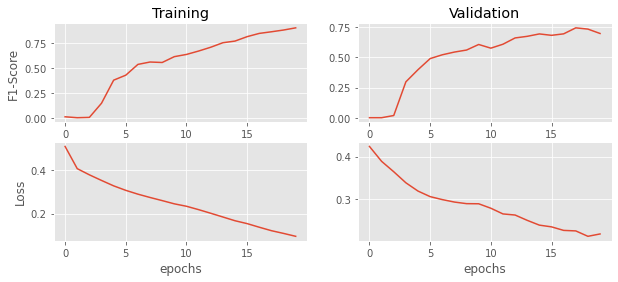

Fold 2 - Loss: 0.23577488958835602 F1-Score: 0.6393418312072754


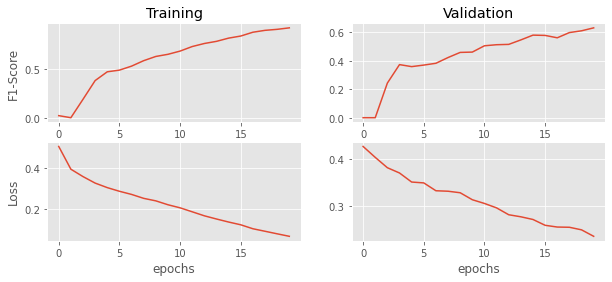

Fold 3 - Loss: 0.2675139307975769 F1-Score: 0.5938258767127991


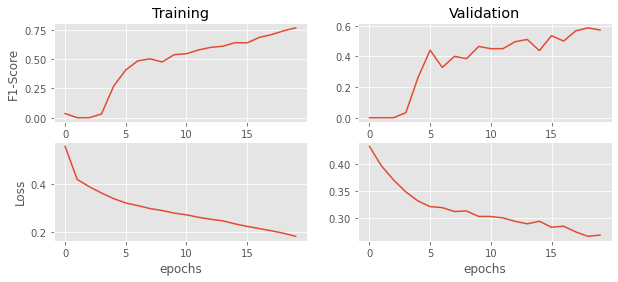

Fold 4 - Loss: 0.17654193937778473 F1-Score: 0.7629429697990417


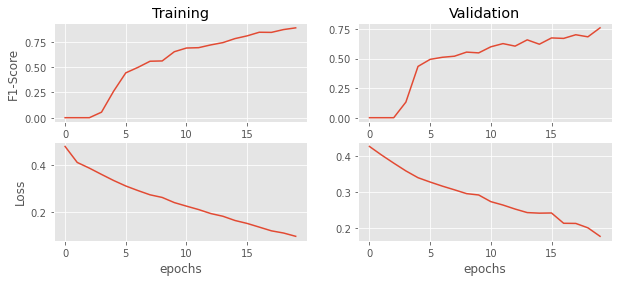

Fold 5 - Loss: 0.21988829970359802 F1-Score: 0.7002704739570618


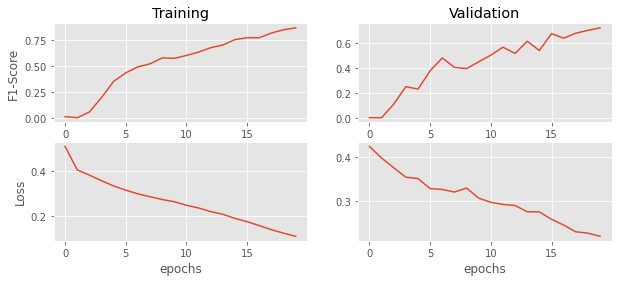

Average loss: 0.22379396855831146
Average F1-Score: 0.6750899672508239 (+- 0.05700845517613948)


In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

#get categorical and continuous data columns
categorical = list(X.select_dtypes(include='int64').columns)
continuous = list(X.select_dtypes(include='float64').columns)

#remove all categorical features that are in crossed list
categorical = [x for x in categorical if x not in cross_col_df_names]

f1_per_fold1 = []
loss_per_fold1 = []
fold_num = 1

#loop through each fold
for train, test in cv.split(X.to_numpy(), y.to_numpy()):
    #get train and test sets
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train].to_numpy(), y.iloc[test].to_numpy()
    
    #get train and test categorical features
    X_train_cat = X_train[categorical].to_numpy()
    X_test_cat = X_test[categorical].to_numpy()
    
    #get train and test continuous features
    X_train_cont = X_train[continuous].to_numpy()
    X_test_cont = X_test[continuous].to_numpy()
    
    #get train and test crossed features
    X_train_cross = X_train[cross_col_df_names].to_numpy()
    X_test_cross = X_test[cross_col_df_names].to_numpy()
    
    #we need to create separate lists for each branch
    wide_outputs = []

    #CROSSED DATA INPUT
    input_cross = Input(shape=(X_train_cross.shape[1],), dtype='int64', name='cross')
    for idx, col in enumerate(cross_col_df_names):
        #track what the maximum integer value will be for this variable
        #which is the same as the number of categories
        N = max(X_train[col].max(), X_test[col].max()) + 1
        #this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cross, idx, axis=1)
        #now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)),
                      input_length=1,
                      name=col+'_embed')(x)
        #save these outputs to concatenate later
        wide_outputs.append(x)
    
    #now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(wide_outputs, name='wide_concat')
    
    #reset this input branch
    all_deep_branch_outputs = []
    
    #CATEGORICAL DATA INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical')
    for idx, col in enumerate(categorical):
        #track what the maximum integer value will be for this variable
        #which is the same as the number of categories
        N = max(X_train[col].max(), X_test[col].max()) + 1
        #this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
        #now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N,
                      output_dim=int(np.sqrt(N)),
                      input_length=1,
                      name=col+'_embed')(x)
        #save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    #NUMERIC DATA INPUT
    #create dense input branch for numeric
    input_cont = Input(shape=(X_train_cont.shape[1],), name='continuous')
    x_dense = Dense(units=22, activation='relu', name='cont_1')(input_cont)
    all_deep_branch_outputs.append(x_dense)
    
    #merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs, name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
    #merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch], name='wide_deep_concat')
    final_branch = Dense(units=1, activation='sigmoid', name='combined')(final_branch)
    
    model1 = Model(inputs=[input_cross,input_cat,input_cont], outputs=final_branch)
    
    model1.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=[f1])
    
    history = model1.fit([X_train_cross,X_train_cat,X_train_cont],
                         y_train,
                         epochs=20,
                         batch_size=50,
                         verbose=0,
                         validation_data=([X_test_cross,X_test_cat,X_test_cont],
                                          y_test))
    
    loss, f1_score = model1.evaluate([X_test_cross,X_test_cat,X_test_cont],
                                     y_test, verbose=0)
     
    print(f'Fold {fold_num} - Loss: {loss} F1-Score: {f1_score}')
    f1_per_fold1.append(f1_score)
    loss_per_fold1.append(loss)
    
    fold_num += 1
    
    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(history.history['f1'])
    plt.ylabel('F1-Score')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_f1'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    plt.show()

print(f'Average loss: {np.mean(loss_per_fold1)}')
print(f'Average F1-Score: {np.mean(f1_per_fold1)} (+- {np.std(f1_per_fold1)})')

__Analyze first model outputs__

__Describe second model__

Fold 1 - Loss: 0.2541636824607849 F1-Score: 0.7614207863807678


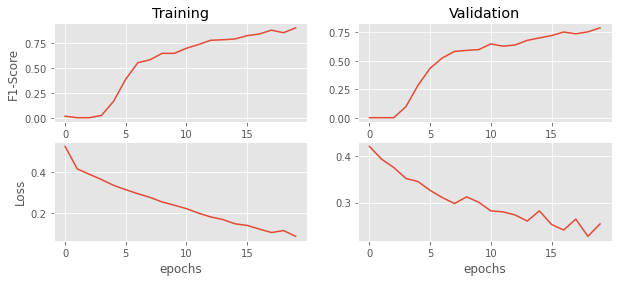

Fold 2 - Loss: 0.26070091128349304 F1-Score: 0.6799762845039368


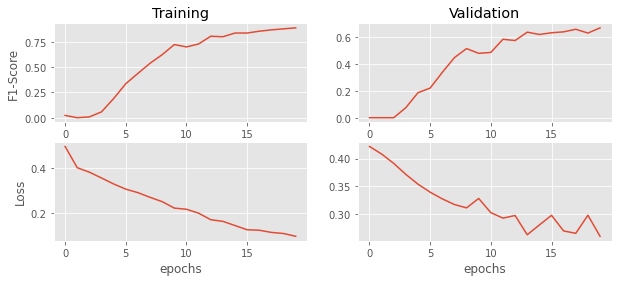

Fold 3 - Loss: 0.22995318472385406 F1-Score: 0.7156874537467957


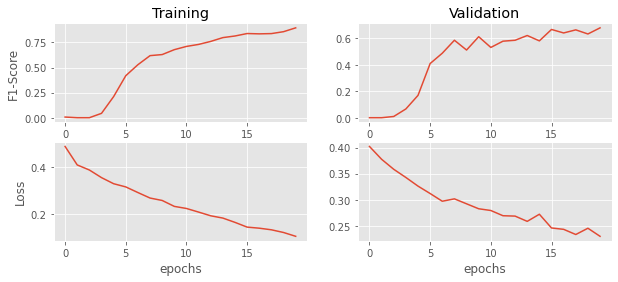

Fold 4 - Loss: 0.252503901720047 F1-Score: 0.6768868565559387


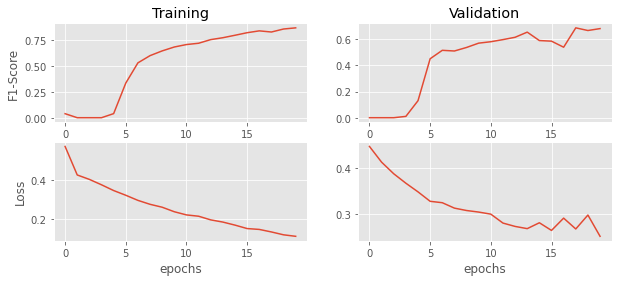

Fold 5 - Loss: 0.23808252811431885 F1-Score: 0.7183243036270142


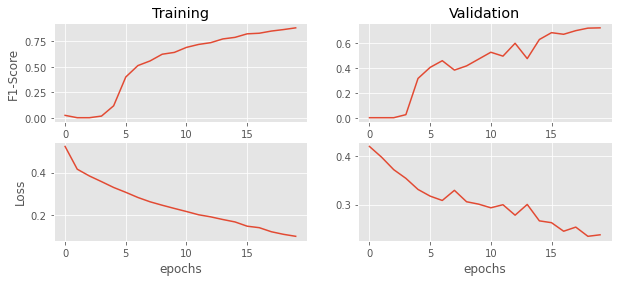

Average loss: 0.24708084166049957
Average F1-Score: 0.7104591369628906 (+- 0.030798013443062468)


In [11]:
f1_per_fold2 = []
loss_per_fold2 = []
fold_num = 1

#loop through each fold
for train, test in cv.split(X.to_numpy(), y.to_numpy()):
    #get train and test sets
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train].to_numpy(), y.iloc[test].to_numpy()
    
    #get train and test categorical features
    X_train_cat = X_train[categorical].to_numpy()
    X_test_cat = X_test[categorical].to_numpy()
    
    #get train and test continuous features
    X_train_cont = X_train[continuous].to_numpy()
    X_test_cont = X_test[continuous].to_numpy()
    
    #get train and test crossed features
    X_train_cross = X_train[cross_col_df_names].to_numpy()
    X_test_cross = X_test[cross_col_df_names].to_numpy()
    
    #we need to create separate lists for each branch
    wide_outputs = []

    #CROSSED DATA INPUT
    input_cross = Input(shape=(X_train_cross.shape[1],), dtype='int64', name='cross')
    for idx, col in enumerate(cross_col_df_names):
        #track what the maximum integer value will be for this variable
        #which is the same as the number of categories
        N = max(X_train[col].max(), X_test[col].max()) + 1
        #this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cross, idx, axis=1)
        #now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)),
                      input_length=1,
                      name=col+'_embed')(x)
        #save these outputs to concatenate later
        wide_outputs.append(x)
    
    #now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(wide_outputs, name='cross_concat')
    
    #reset this input branch
    all_deep_branch_outputs = []
    
    #CATEGORICAL DATA INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical')
    for idx, col in enumerate(categorical):
        #track what the maximum integer value will be for this variable
        #which is the same as the number of categories
        N = max(X_train[col].max(), X_test[col].max()) + 1
        #this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
        #now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N,
                      output_dim=int(np.sqrt(N)),
                      input_length=1,
                      name=col+'_embed')(x)
        #save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    #NUMERIC DATA INPUT
    #create dense input branch for numeric
    input_cont = Input(shape=(X_train_cont.shape[1],), name='continuous')
    #add 2 more dense layers and change number of neurons
    x_dense = Dense(units=50, activation='relu', name='cont_1')(input_cont)
    x_dense = Dense(units=25, activation='relu', name='cont_2')(x_dense)
    x_dense = Dense(units=25, activation='relu', name='cont_3')(x_dense)
    all_deep_branch_outputs.append(x_dense)
    
    #merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs, name='concat_embeds')
    #add one more dense layer, change neurons, and 3 dropout layers
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dropout(0.2)(deep_branch) #<--- Add dropout
    deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dropout(0.2)(deep_branch) #<--- Add dropout
    deep_branch = Dense(units=25,activation='relu', name='deep3')(deep_branch)
    deep_branch = Dropout(0.2)(deep_branch) #<--- Add dropout
    deep_branch = Dense(units=10,activation='relu', name='deep4')(deep_branch)
    
    #merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch], name='wide_deep_concat')
    final_branch = Dense(units=1, activation='sigmoid', name='combined')(final_branch)
    
    model2 = Model(inputs=[input_cross,input_cat,input_cont], outputs=final_branch)
    
    model2.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=[f1])
    
    history = model2.fit([X_train_cross,X_train_cat,X_train_cont],
                         y_train,
                         epochs=20,
                         batch_size=50,
                         verbose=0,
                         validation_data=([X_test_cross,X_test_cat,X_test_cont],
                                          y_test))
    
    loss, f1_score = model2.evaluate([X_test_cross,X_test_cat,X_test_cont],
                                     y_test, verbose=0)
    
    print(f'Fold {fold_num} - Loss: {loss} F1-Score: {f1_score}')
    f1_per_fold2.append(f1_score)
    loss_per_fold2.append(loss)
    
    fold_num += 1
    
    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(history.history['f1'])
    plt.ylabel('F1-Score')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_f1'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    plt.show()

print(f'Average loss: {np.mean(loss_per_fold2)}')
print(f'Average F1-Score: {np.mean(f1_per_fold2)} (+- {np.std(f1_per_fold2)})')

__Analyze second model outputs__

__Describe third model__

Fold 1 - Loss: 0.21111175417900085 F1-Score: 0.7666210532188416


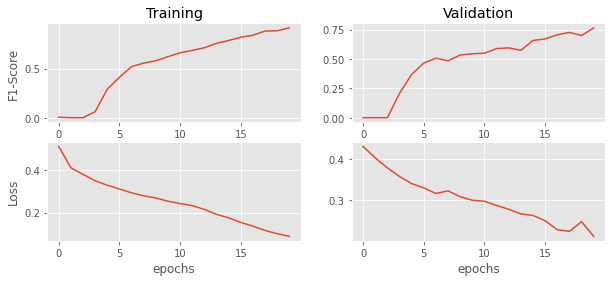

Fold 2 - Loss: 0.2164444923400879 F1-Score: 0.7329146862030029


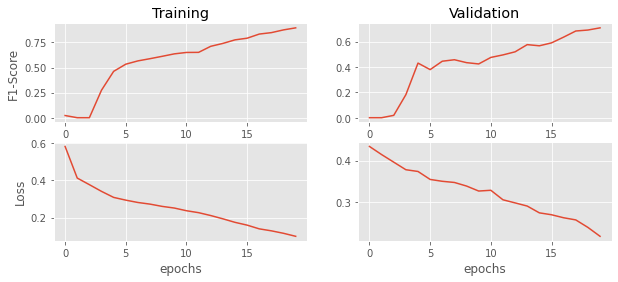

Fold 3 - Loss: 0.21002444624900818 F1-Score: 0.7275195717811584


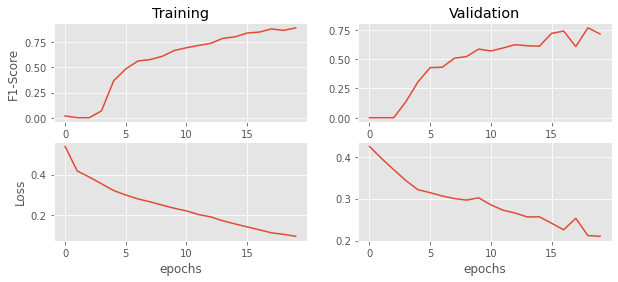

Fold 4 - Loss: 0.15530984103679657 F1-Score: 0.8347572684288025


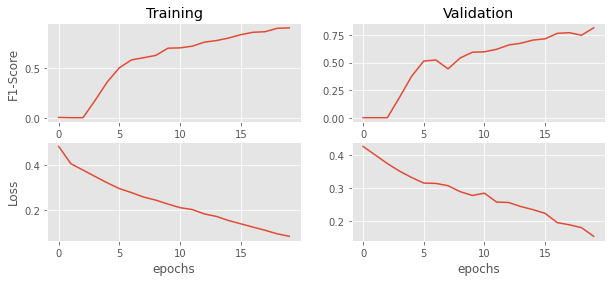

Fold 5 - Loss: 0.16662457585334778 F1-Score: 0.7133105397224426


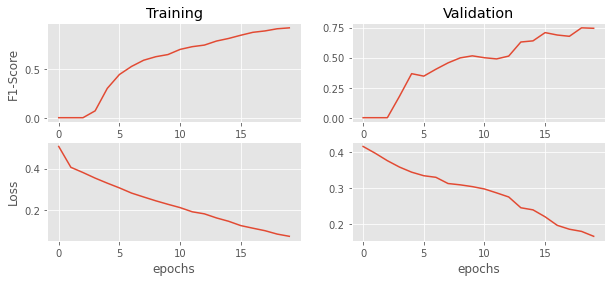

Average loss: 0.19190302193164827
Average F1-Score: 0.7550246238708496 (+- 0.04353668299790624)


In [13]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

f1_per_fold3 = []
loss_per_fold3 = []
fold_num = 1

tprs1 = []
aucs1 = []
mean_fpr = np.linspace(0, 1, 100)

#loop through each fold
for train, test in cv.split(X.to_numpy(), y.to_numpy()):
    #get train and test sets
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train].to_numpy(), y.iloc[test].to_numpy()
    
    #get train and test categorical features
    X_train_cat = X_train[categorical].to_numpy()
    X_test_cat = X_test[categorical].to_numpy()
    
    #get train and test continuous features
    X_train_cont = X_train[continuous].to_numpy()
    X_test_cont = X_test[continuous].to_numpy()
    
    #get train and test crossed features
    X_train_cross = X_train[cross_col_df_names].to_numpy()
    X_test_cross = X_test[cross_col_df_names].to_numpy()
    
    #we need to create separate lists for each branch
    wide_outputs = []

    #CROSSED DATA INPUT
    input_cross = Input(shape=(X_train_cross.shape[1],), dtype='int64', name='cross')
    for idx, col in enumerate(cross_col_df_names):
        #track what the maximum integer value will be for this variable
        #which is the same as the number of categories
        N = max(X_train[col].max(), X_test[col].max()) + 1
        #this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cross, idx, axis=1)
        #now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)),
                      input_length=1,
                      name=col+'_embed')(x)
        #save these outputs to concatenate later
        wide_outputs.append(x)
    
    #now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(wide_outputs, name='cross_concat')
    wide_branch = Dense(units=40, activation='relu', name='cross_1')(wide_branch)
    wide_branch = Dense(units=40, activation='relu', name='cross_2')(wide_branch)
    wide_branch = Dropout(.2)(wide_branch)
    
    #reset this input branch
    all_deep_branch_outputs = []
    
    #CATEGORICAL DATA INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical')
    for idx, col in enumerate(categorical):
        #track what the maximum integer value will be for this variable
        #which is the same as the number of categories
        N = max(X_train[col].max(), X_test[col].max()) + 1
        #this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
        #now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N,
                      output_dim=int(np.sqrt(N)),
                      input_length=1,
                      name=col+'_embed')(x)
        #save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    #NUMERIC DATA INPUT
    #create dense input branch for numeric
    input_cont = Input(shape=(X_train_cont.shape[1],), name='continuous')
    #add 2 more dense layers and change number of neurons
    x_dense = Dense(units=25, activation='relu', name='cont_1')(input_cont)
    x_dense = Dense(units=10, activation='relu', name='cont_2')(x_dense)
    all_deep_branch_outputs.append(x_dense)
    
    #merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs, name='concat_embeds')
    #add one more dense layer, change neurons, and 3 dropout layers
    deep_branch = Dense(units=30,activation='relu', name='deep1')(deep_branch)
    #deep_branch = Dropout(0.2)(deep_branch) #<--- Add dropout
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep3')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep4')(deep_branch)
    
    #merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch], name='wide_deep_concat')
    final_branch = Dense(units=1, activation='sigmoid', name='combined')(final_branch)
    
    model3 = Model(inputs=[input_cross,input_cat,input_cont], outputs=final_branch)
    
    model3.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=[f1])
    
    history = model3.fit([X_train_cross,X_train_cat,X_train_cont],
                         y_train,
                         epochs=20,
                         batch_size=50,
                         verbose=0,
                         validation_data=([X_test_cross,X_test_cat,X_test_cont],
                                          y_test))
    
    loss, f1_score = model3.evaluate([X_test_cross,X_test_cat,X_test_cont],
                                     y_test, verbose=0)
    
    yhat = np.round(model3.predict([X_test_cross,X_test_cat,X_test_cont]))
    fpr, tpr, _ = roc_curve(y_test, yhat)
    tprs1.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs1.append(roc_auc)
    
    print(f'Fold {fold_num} - Loss: {loss} F1-Score: {f1_score}')
    f1_per_fold3.append(f1_score)
    loss_per_fold3.append(loss)
    
    fold_num += 1
    
    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(history.history['f1'])
    plt.ylabel('F1-Score')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_f1'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    plt.show()

print(f'Average loss: {np.mean(loss_per_fold3)}')
print(f'Average F1-Score: {np.mean(f1_per_fold3)} (+- {np.std(f1_per_fold3)})')

__Analyze third model outputs__

### 2.2 Generalization Performance

- __[2 points]__ Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly. 
- *Note: Altering number of layers counts as a new model (changing activation functions, change neurons, new feature crossings, new number of layers) select one that performs the best (statistical test)*

In [14]:
t = 2.26 / np.sqrt(5)

f1_per_fold1 = np.asarray(f1_per_fold1)
f1_per_fold2 = np.asarray(f1_per_fold2)
f1_per_fold3 = np.asarray(f1_per_fold3)

print("Avg error rate of model 1:", np.mean(1-f1_per_fold1))
print("Avg error rate of model 2:", np.mean(1-f1_per_fold2))
print("Avg error rate of model 3:", np.mean(1-f1_per_fold3))

e = (1 - f1_per_fold1) - (1 - f1_per_fold2)
stdtot = np.std(e)
dbar = np.mean(e)
print('\nConfidence interval range (1&2):', dbar-t*stdtot, dbar+t*stdtot)

e = (1 - f1_per_fold1) - (1 - f1_per_fold3)
stdtot = np.std(e)
dbar = np.mean(e)
print('Confidence interval range (1&3):', dbar-t*stdtot, dbar+t*stdtot)

e = (1 - f1_per_fold2) - (1 - f1_per_fold3)
stdtot = np.std(e)
dbar = np.mean(e)
print('Confidence interval range (2&3):', dbar-t*stdtot, dbar+t*stdtot)

Avg error rate of model 1: 0.324910032749176
Avg error rate of model 2: 0.28954086303710935
Avg error rate of model 3: 0.24497537612915038

Confidence interval range (1&2): -0.035754399754217195 0.10649273917835049
Confidence interval range (1&3): 0.040336539609880616 0.11953277363017065
Confidence interval range (2&3): -0.016055292842652537 0.1051862666585705


### 2.3 Performance Difference Between Best Wide & Deep Network & Standard MLP

- __[1 points]__ Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). For classification tasks, use the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical method to compare the performance of different models. 
- *Note: Build MLP in Keras and compare model (use ROC curve)*

Fold 1 - Loss: 0.14947348833084106 F1-Score: 0.8496760725975037


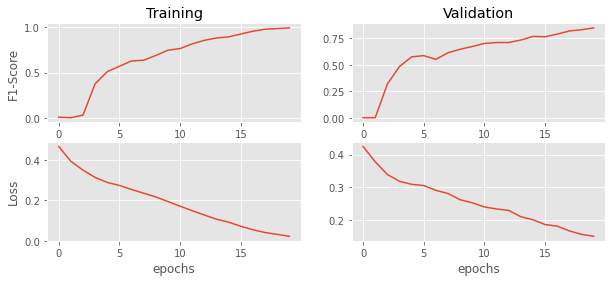

Fold 2 - Loss: 0.18800806999206543 F1-Score: 0.7481914162635803


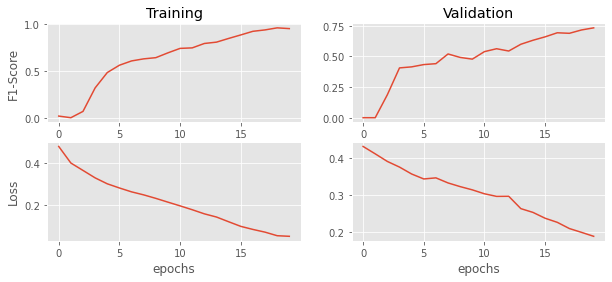

Fold 3 - Loss: 0.18627093732357025 F1-Score: 0.7553573846817017


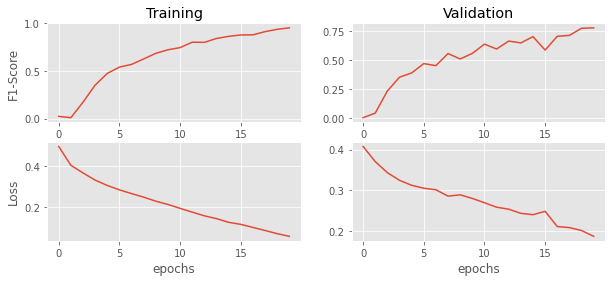

Fold 4 - Loss: 0.1260828971862793 F1-Score: 0.848742663860321


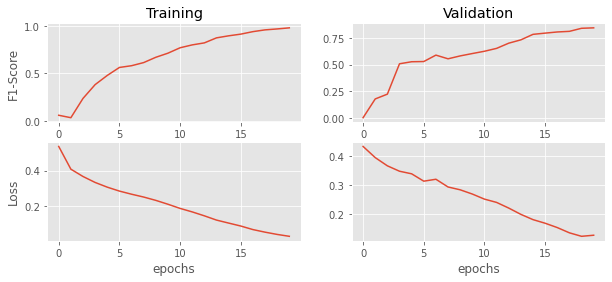

Fold 5 - Loss: 0.16022135317325592 F1-Score: 0.8429722189903259


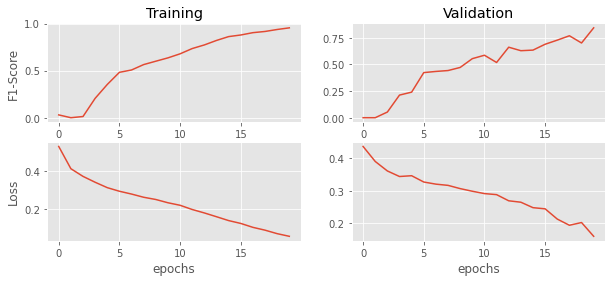

Average loss: 0.1620113492012024
Average F1-Score: 0.8089879512786865 (+- 0.0468259483281571)


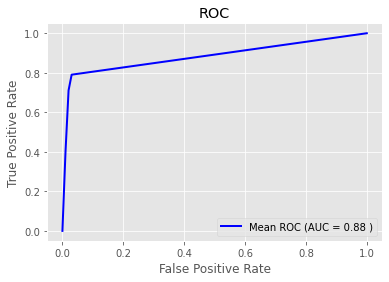

In [15]:
f1_per_fold4 = []
loss_per_fold4 = []
fold_num = 1

tprs2 = []
aucs2 = []
mean_fpr = np.linspace(0, 1, 100)

#loop through each fold
for train, test in cv.split(X.to_numpy(), y.to_numpy()):
    #get train and test sets
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train].to_numpy(), y.iloc[test].to_numpy()
    
    #get train and test categorical features
    X_train_cat = X_train[categorical].to_numpy()
    X_test_cat = X_test[categorical].to_numpy()
    
    #get train and test continuous features
    X_train_cont = X_train[continuous].to_numpy()
    X_test_cont = X_test[continuous].to_numpy()
    
    #get train and test crossed features
    X_train_cross = X_train[cross_col_df_names].to_numpy()
    X_test_cross = X_test[cross_col_df_names].to_numpy()
    
    #we need to create separate lists for each branch
    all_branch_outputs = []

    #CROSSED DATA INPUT
    input_cross = Input(shape=(X_train_cross.shape[1],), dtype='int64', name='cross')
    for idx, col in enumerate(cross_col_df_names):
        #track what the maximum integer value will be for this variable
        #which is the same as the number of categories
        N = max(X_train[col].max(), X_test[col].max()) + 1
        #this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cross, idx, axis=1)
        #now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)),
                      input_length=1,
                      name=col+'_embed')(x)
        #save these outputs to concatenate later
        all_branch_outputs.append(x)
    

    #CATEGORICAL DATA INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical')
    for idx, col in enumerate(categorical):
        #track what the maximum integer value will be for this variable
        #which is the same as the number of categories
        N = max(X_train[col].max(), X_test[col].max()) + 1
        #this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
        #now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N,
                      output_dim=int(np.sqrt(N)),
                      input_length=1,
                      name=col+'_embed')(x)
        #save these outputs to concatenate later
        all_branch_outputs.append(x)
    
    #NUMERIC DATA INPUT
    #create dense input branch for numeric
    input_cont = Input(shape=(X_train_cont.shape[1],), name='continuous')
    x_dense = Dense(units=22, activation='relu', name='cont_1')(input_cont)
    all_branch_outputs.append(x_dense)
    
    #merge the deep branches together
    final_branch = concatenate(all_branch_outputs, name='concat_embeds')
    final_branch = Dense(units=50,activation='relu', name='deep1')(final_branch)
    final_branch = Dense(units=25,activation='relu', name='deep2')(final_branch)
    final_branch = Dense(units=10,activation='relu', name='deep3')(final_branch)
    final_branch = Dense(units=1, activation='sigmoid', name='combined')(final_branch)
    
    model4 = Model(inputs=[input_cross,input_cat,input_cont], outputs=final_branch)
    
    model4.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=[f1])
    
    history = model4.fit([X_train_cross,X_train_cat,X_train_cont],
                         y_train,
                         epochs=20,
                         batch_size=50,
                         verbose=0,
                         validation_data=([X_test_cross,X_test_cat,X_test_cont],
                                          y_test))
    
    loss, f1_score = model4.evaluate([X_test_cross,X_test_cat,X_test_cont],
                                     y_test, verbose=0)
    
    yhat = np.round(model4.predict([X_test_cross,X_test_cat,X_test_cont]))
    fpr, tpr, _ = roc_curve(y_test, yhat)
    tprs2.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs2.append(roc_auc)
    
     
    print(f'Fold {fold_num} - Loss: {loss} F1-Score: {f1_score}')
    f1_per_fold4.append(f1_score)
    loss_per_fold4.append(loss)
    
    fold_num += 1
    
    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(history.history['f1'])
    plt.ylabel('F1-Score')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_f1'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    plt.show()

print(f'Average loss: {np.mean(loss_per_fold4)}')
print(f'Average F1-Score: {np.mean(f1_per_fold4)} (+- {np.std(f1_per_fold4)})')

mean_tpr = np.mean(tprs2, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

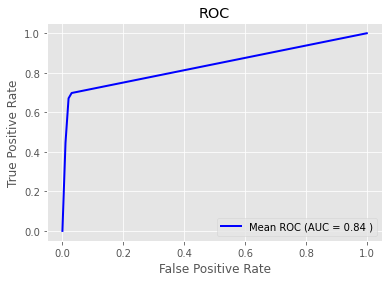

In [16]:
mean_tpr = np.mean(tprs1, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [17]:
t = 2.26 / np.sqrt(5)

f1_per_fold3 = np.asarray(f1_per_fold3)
f1_per_fold4 = np.asarray(f1_per_fold4)

print("Avg error rate of model 3:", np.mean(1-f1_per_fold3))
print("Avg error rate of model 4:", np.mean(1-f1_per_fold4))

e = (1 - f1_per_fold3) - (1 - f1_per_fold4)
stdtot = np.std(e)
dbar = np.mean(e)
print('\nConfidence interval range (3&4):', dbar-t*stdtot, dbar+t*stdtot)

Avg error rate of model 3: 0.24497537612915038
Avg error rate of model 4: 0.19101204872131347

Confidence interval range (3&4): 0.007970250956193248 0.09995640385948058


***

## 3 Exceptional Work: ...

- 5000 students: You have free reign to provide additional analyses.
- One idea __(required for 7000 level students):__ Capture the embedding weights from the deep network and (if needed) perform dimensionality reduction on the output of these embedding layers (only if needed). That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data.
- *Note: Capture trained embedding weights (columns of W) (may need to perform PCA) and figure out what categorical variable (one we were most interested in) is associated with it*

***

## Resources

[1] HR Analytics Case Study dataset. https://www.kaggle.com/vjchoudhary7/hr-analytics-case-study

[2] HR Analytics Case Study example notebook. https://www.kaggle.com/artyomkolas/hr-analytics-2

[3] When to use Stratified K-Fold. https://towardsdatascience.com/stratified-k-fold-what-it-is-how-to-use-it-cf3d107d3ea2#:~:text=Stratified%20kfold%20cross%20validation%20is%20typically%20useful%20when%20we%20have,is%20on%20the%20small%20side

[4] Small Business Statistics. https://smallbiztrends.com/small-business-statistics